<a name='1'></a>
## 1 - Packages

In [1]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from resnets_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import pandas as pd
from resnets_utils import *




%matplotlib inline

In [2]:
# 
#  FUNCTION 1 : identity_block

def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    ### START CODE HERE
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', kernel_initializer = initializer(seed = 0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) 
    X = Activation('relu')(X) 
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

In [3]:
# 
# FUNCTION 2 : convolutional_block

def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(filters = F1, kernel_size = (1,1), strides = (s,s),padding = 'valid',kernel_initializer = initializer(seed = 0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)
    

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [4]:
# 
# FUNCTION: ResNet18

def ResNet18(input_shape = (64, 64, 3), classes = 6):
    """
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1) #3,4
    X = identity_block(X, 3, [64, 64, 256]) #5,6
 

   
    
    ## Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)#7,8
    X = identity_block(X, 3, [128, 128, 512]) #9,10
    
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)#11,12
    X = identity_block(X, 3, [256, 256, 1024]) #13,14
    X = identity_block(X, 3, [256, 256, 1024]) #15,16
    
    # Dropout layer
    X = Dropout(0.5)(X)
    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2,2), name = 'avg_pool')(X) #17
  
    
    ### END CODE HERE

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [5]:
model = ResNet18(input_shape = (64, 64, 3), classes = 6)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                   

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


Epoch 1/20
31/31 [==============================] - 6s 75ms/step - loss: 1.8748 - accuracy: 0.5278 - val_loss: 1.2114 - val_accuracy: 0.6389
Epoch 2/20
31/31 [==============================] - 1s 44ms/step - loss: 0.4612 - accuracy: 0.8426 - val_loss: 1.1968 - val_accuracy: 0.6481
Epoch 3/20
31/31 [==============================] - 1s 44ms/step - loss: 0.2385 - accuracy: 0.9218 - val_loss: 0.5522 - val_accuracy: 0.8519
Epoch 4/20
31/31 [==============================] - 1s 44ms/step - loss: 0.0894 - accuracy: 0.9671 - val_loss: 0.3689 - val_accuracy: 0.8611
Epoch 5/20
31/31 [==============================] - 1s 44ms/step - loss: 0.1593 - accuracy: 0.9465 - val_loss: 0.6426 - val_accuracy: 0.8148
Epoch 6/20
31/31 [==============================] - 1s 44ms/step - loss: 0.2186 - accuracy: 0.9362 - val_loss: 0.5191 - val_accuracy: 0.8426
Epoch 7/20
31/31 [==============================] - 1s 44ms/step - loss: 0.2581 - accuracy: 0.9074 - val_loss: 0.5403 - val_accuracy: 0.8981
Epoch 8/20
31

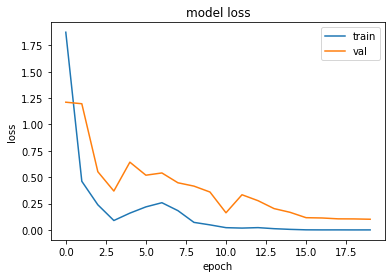

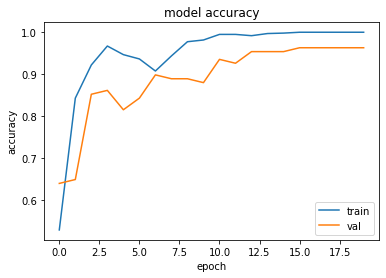

In [8]:
history = model.fit(X_train, Y_train, epochs = 20, validation_split = 0.1, batch_size = 32)
plt.plot(history.history["loss"])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'best')
plt.savefig('resnet18_2_loss.pdf')
plt.show()
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'best')
plt.savefig('resnet18_2_accuracy.pdf')
plt.show()

In [9]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 0s 51ms/step - loss: 0.1118 - accuracy: 0.9750
Loss = 0.11183526366949081
Test Accuracy = 0.9750000238418579
